# Dataset Builder
This file is used to generate dataset used for model training from given csv file

In [2]:
import numpy as np
import csv
import json
import random
import h5py
from Settings import Settings
from FileUtils import FileUtils

## Read CSV File

In [3]:
csv_file = open(Settings.data_path, "r")
csv_reader = csv.reader(csv_file)

data_list = list() # contains data
label_dict = dict() # assign index to labels
label_index = 0

vocab = set()
word_freq = dict()
sentenceLength = dict()  # used for statistic analysis

# notice label indices and word indices are both start from 1

for line in csv_reader:
    label, doc = line
    words = doc.strip().split()
    sentenceLength[len(words)] = sentenceLength.get(len(words), 0) + 1
    if not label_dict.get(label):
        label_index += 1
        label_dict[label] = label_index
        
    for word in words:
        vocab.add(word)
        word_freq[word] = word_freq.get(word, 0) + 1
        
    data_list.append([label_dict.get(label), words])
        
csv_file.close()

In [4]:
print(label_dict)

{'DELETION OF INTEREST': 1, 'RETURNED CHECK': 2, 'BILL': 3, 'POLICY CHANGE': 4, 'CANCELLATION NOTICE': 5, 'DECLARATION': 6, 'CHANGE ENDORSEMENT': 7, 'NON-RENEWAL NOTICE': 8, 'BINDER': 9, 'REINSTATEMENT NOTICE': 10, 'EXPIRATION NOTICE': 11, 'INTENT TO CANCEL NOTICE': 12, 'APPLICATION': 13, 'BILL BINDER': 14}


In [5]:
label_idx_dict = dict()
for key in label_dict:
    label_idx_dict[label_dict.get(key)] = key

In [6]:
print(label_idx_dict)

{1: 'DELETION OF INTEREST', 2: 'RETURNED CHECK', 3: 'BILL', 4: 'POLICY CHANGE', 5: 'CANCELLATION NOTICE', 6: 'DECLARATION', 7: 'CHANGE ENDORSEMENT', 8: 'NON-RENEWAL NOTICE', 9: 'BINDER', 10: 'REINSTATEMENT NOTICE', 11: 'EXPIRATION NOTICE', 12: 'INTENT TO CANCEL NOTICE', 13: 'APPLICATION', 14: 'BILL BINDER'}


## Store label Maps
For backup

In [7]:
FileUtils.save_dict(label_dict, "LabelToIndex.json")
FileUtils.save_dict(label_idx_dict, "IndexToLabel.json")

## Clean vocabulary
Since we statistics the freqency, we remove those words rarely show up

In [12]:
word_list = list(vocab)
new_vocab = vocab.copy()
for word in word_list:
    if word_freq.get(word) < 2:  # remove words only occurs twice in our original data
        new_vocab.remove(word)
print(len(vocab), len(new_vocab))

1037934 300995


In [14]:
# build word map
word_map = dict()
word_map["UNK"] = 0  # unknown word
word_map["PAD"] = 1  # padding word
for i, word in enumerate(sorted(list(new_vocab))): # ensure we generate same map each time
    word_map[word] = i + 2

new_vocab.add("UNK")
new_vocab.add("PAD")
# save word map
FileUtils.save_dict(word_map, "WordToIndex.json")

In [15]:
print(len(word_map))

300997


In [16]:
word_map.get("9b6646b690ff")

182985

## Index Original Data


In [17]:
inplace_list = data_list[:] # copy

for label, words in inplace_list:
    for i, word in enumerate(words):
        words[i] = word_map.get(word, 0)

In [18]:
print(inplace_list[0])

[1, [264034, 252726, 109345, 279100, 104751, 278019, 34145, 147553, 296178, 125804, 99304, 44420, 164601, 58683, 290811, 222466, 32112, 210189, 104751, 244038, 44420, 211770, 262000, 22763, 30566, 34145, 45226, 215471, 284579, 37300, 269112, 126016, 114056, 65145, 245076, 105682, 184551, 99304, 164601, 0, 142995, 44069, 213888, 159733, 73426, 10873, 77787, 44420, 27845, 248974, 146831, 283820, 47766, 73857, 265640, 286277, 277823, 244780, 257328, 14193, 103891, 246874, 59204, 44420, 39572, 285502, 257068, 184641, 125223, 78985, 126016, 164808, 215991, 206533, 226964, 238876, 146831, 180663, 103891, 300870, 248974, 92120, 146831, 27845, 103891, 158819, 54069, 257328, 248974, 22660, 257068, 206196, 250441, 147756, 238876, 146831, 145900, 248974, 146831, 222276, 92120, 229822, 264034, 87967, 125992, 242649, 48001, 187214, 280862, 293599, 173736, 9546, 276034, 164091, 297029, 149060, 81126, 61336, 147756, 73207, 84223, 71741, 96574, 64735, 229822, 238876, 218099, 0, 18917, 103891, 209286, 

## Divide documents into chunks

In [19]:
import matplotlib.pyplot as plt

In [20]:
# we need to determine how to slice the document
length = list(sentenceLength.keys())
freq = [sentenceLength.get(i) for i in length]

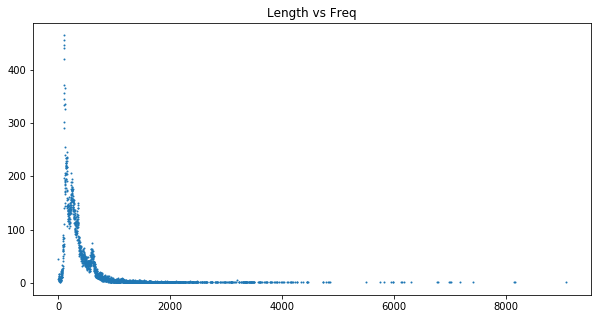

464


In [21]:
plt.figure(figsize=(10,5))
plt.scatter(length, freq, s=1)
plt.title("Length vs Freq")
plt.show()

print(max(freq))

In [22]:
# so I determined to divide each document to chunks contains 200 words, and padding if length < 200
print(Settings.seq_size)

200


In [23]:
records = list() # contains label/chunk pair
label_freq_dict = dict() # to see how many chunks belongs to one label

for label, words in inplace_list:
    sentences = FileUtils.divide_sentence(words, Settings.seq_size)
    for s in sentences:
        records.append([label, s])
        label_freq_dict[label] = label_freq_dict.get(label, list()) + [s]

In [24]:
print(len(records))

116524


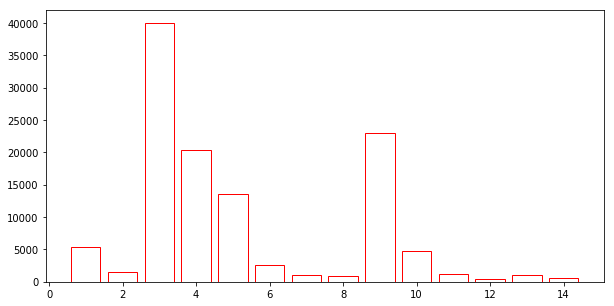

In [25]:
plt.figure(figsize=(10,5))
x = list(label_freq_dict.keys())
y = [len(label_freq_dict.get(key)) for key in x]

plt.bar(range(1, 15), y, 
        align='center', 
        color= (0,0,0,0),
        edgecolor = 'r',
        label='label vs Freq')
plt.show()


In [26]:
print(sorted(y))

[395, 652, 880, 1030, 1049, 1224, 1460, 2663, 4774, 5353, 13574, 20448, 22994, 40028]


## Then we need to somewhole balance the data

In [28]:
for key in label_freq_dict:
    words_list = label_freq_dict.get(key)
    
    # over-sampling
    i = 1
    while len(words_list) < 1000:
        a = words_list[-i]
        words_list.insert(0, a)
        i +=1 
        
    label_freq_dict[key] = words_list

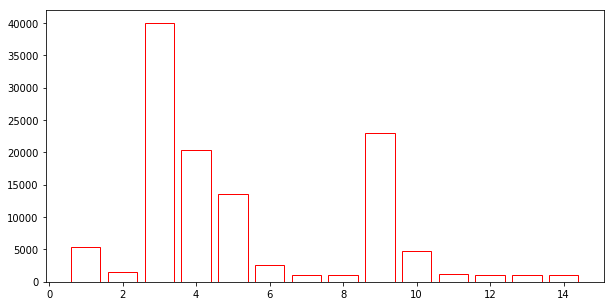

[1000, 1000, 1000, 1030, 1049, 1224, 1460, 2663, 4774, 5353, 13574, 20448, 22994, 40028]


In [29]:
plt.figure(figsize=(10,5))
x = list(label_freq_dict.keys())
y = [len(label_freq_dict.get(key)) for key in x]

plt.bar(range(1, 15), y, 
        align='center', 
        color= (0,0,0,0),
        edgecolor = 'r',
        label='label vs Freq')
plt.show()
print(sorted(y))

### From the bar chart we can see a serious inbalance between different labels

I will choose 1000 chunks for each label to build model train sets

In [30]:
records = list() # discard the old one
for key in label_freq_dict:
    
    # we down-sampling data which is too much
    current_choose = label_freq_dict.get(key)[: 3000]
    item = [[key, words] for words in current_choose]
    records += item

In [31]:
print(records[0])

[1, [264034, 252726, 109345, 279100, 104751, 278019, 34145, 147553, 296178, 125804, 99304, 44420, 164601, 58683, 290811, 222466, 32112, 210189, 104751, 244038, 44420, 211770, 262000, 22763, 30566, 34145, 45226, 215471, 284579, 37300, 269112, 126016, 114056, 65145, 245076, 105682, 184551, 99304, 164601, 0, 142995, 44069, 213888, 159733, 73426, 10873, 77787, 44420, 27845, 248974, 146831, 283820, 47766, 73857, 265640, 286277, 277823, 244780, 257328, 14193, 103891, 246874, 59204, 44420, 39572, 285502, 257068, 184641, 125223, 78985, 126016, 164808, 215991, 206533, 226964, 238876, 146831, 180663, 103891, 300870, 248974, 92120, 146831, 27845, 103891, 158819, 54069, 257328, 248974, 22660, 257068, 206196, 250441, 147756, 238876, 146831, 145900, 248974, 146831, 222276, 92120, 229822, 264034, 87967, 125992, 242649, 48001, 187214, 280862, 293599, 173736, 9546, 276034, 164091, 297029, 149060, 81126, 61336, 147756, 73207, 84223, 71741, 96574, 64735, 229822, 238876, 218099, 0, 18917, 103891, 209286, 

## Build dataset

In [32]:
total_size = len(records)
train_size = int(total_size * 0.8)
valid_size = int(total_size * 0.1)
test_size = total_size - train_size - valid_size

In [33]:
print(train_size, test_size, valid_size)

22740 2844 2842


In [34]:
index_list = [i for i in range(total_size)]
random.seed(516)
random.shuffle(index_list)
train_indice = index_list[:train_size]
valid_indice = index_list[train_size: train_size + valid_size]
test_indice = index_list[-test_size:]

In [35]:
def build_set(set_name, indice, all_data):
    def create_label(label_index):
        """
        Turn label scalar into a one hot vector
        """
        res = [0 for i in range(14)]
        res[label_index-1] = 1 # because we start at 1
        return res
    
    n = len(indice)
    dataset = h5py.File(set_name, "a")
    dataset.create_dataset('label', shape=(n, 14), dtype=int)
    dataset.create_dataset('chunk', shape=(n, Settings.seq_size), dtype=int)
    
    for i, index in enumerate(indice):
        label, words = all_data[index]
        dataset["label"][i] = create_label(label)
        dataset["chunk"][i] = words
    dataset.close()
    return      

In [36]:
build_set(Settings.train_path, train_indice, records)

In [37]:
build_set(Settings.valid_path, valid_indice, records)

In [38]:
build_set(Settings.test_path, test_indice, records)

In [39]:
t_set = h5py.File(Settings.test_path, 'r')
print(t_set['label'][:5])
print(t_set['chunk'][1])

[[0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0]]
[     0  80866 181799  80594  67163  18917  10423 179947 197950 179141
 111244 206004 267456  32304 262183      0      0  17575 111244  72727
  61246  39934 277283 119931 288290 232074  78140  10423 205903 174249
 288290 146524 261675      0 237304  91272 291222  80866 181799  87967
 188496 229822 277283 291222 293002 137960 188984 237347 252751 280639
 204495 233522 108068 182235 125308 296178 267456 229822 261693 282038
 240415 218099  50854 261693  55339  50854 103891 190572 234293 237854
 268628 106890  32575 216485 276332  16144 163884 197950 248974 282794
 296178 280639 186033 215471 106330 155800 288290 126957 210568 229822
 218099 179932 122497  39934 291222 277283      0 128017 111244 218099
 280862 280862 251820 215945 242649 103891  44420 103891 122497  39934
  44420  81879 164091  86340  97273 149060 107371 145038 107371

# Also build a dataset which is not over/down-sampling

In [40]:
records = list() # contains label/chunk pair
label_freq_dict = dict() # to see how many chunks belongs to one label

for label, words in inplace_list:
    sentences = FileUtils.divide_sentence(words, Settings.seq_size)
    for s in sentences:
        records.append([label, s])
        label_freq_dict[label] = label_freq_dict.get(label, list()) + [s]

In [41]:
records = list()
for key in label_freq_dict:
    current_choose = label_freq_dict.get(key)[:]
    item = [[key, words] for words in current_choose]
    records += item

In [42]:
total_size = len(records)
train_size = int(total_size * 0.8)
valid_size = int(total_size * 0.1)
test_size = total_size - train_size - valid_size

In [43]:
print(train_size, test_size, valid_size)

93219 11653 11652


In [44]:
index_list = [i for i in range(total_size)]
random.seed(516)
random.shuffle(index_list)
train_indice = index_list[:train_size]
valid_indice = index_list[train_size: train_size + valid_size]
test_indice = index_list[-test_size:]

In [45]:
build_set(Settings.e_train_path, train_indice, records)
build_set(Settings.e_test_path, test_indice, records)
build_set(Settings.e_valid_path, valid_indice, records)

In [46]:
t_set = h5py.File(Settings.e_test_path, 'r')
print(t_set['label'][:5])
print(t_set['chunk'][1])

[[0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0]]
[131005 114392 174051 139597      0  39565 174051 139597 219288  55184
 139500 232887      0  55184  55184 134546 236535 147756 236535 168671
  77107 171677 229951 116901  64318 255522 189454 265772 298699 271114
 182624 279905 255522 189454 265772 265400 128647 236879 209286  90998
 188815 182624 298697  50919  69355 220527   4933  34507 164091  53684
 122634 218791 166442 240859 160447 102396   3730 240091 248974  95006
 146831  52615 104909  45878  29668  19289   9842 249931 156055 202774
 280862 127731 131005 137347 248974 129289  80163 248974 179785  76406
 146831 218099 103891 146831 174051  55184 103891 231946 262799  41453
 139597 175932  55184 102396   3730 240859 103891 160447 240091  54932
  95006 278723 136984 122634 218791 166442  91809 164091  44420  53684
 109851  33211 158733 278937 100129  47364 229883 126682 178565